# c3

In [1]:
import sys
sys.path.append("/users/PAS0654/osu8354/root6_14_build/lib") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python2.7/site-packages")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
#%jsroot on

Welcome to JupyROOT 6.14/06


## Import files and names

In [2]:
f1 = ROOT.TFile("/users/PCON0003/cond0068/ARA/AraRoot/analysis/calpul_box/A2_c3_DistroCalPulses_Pol0_CP6_forFit.root")
vpol=f1.Get("Colz_Vpol")
tree = f1.Get("OutputTree")

## <font color='red'>No calpulser 5</font> 

## Calpulser 6

## Let's get the plots first

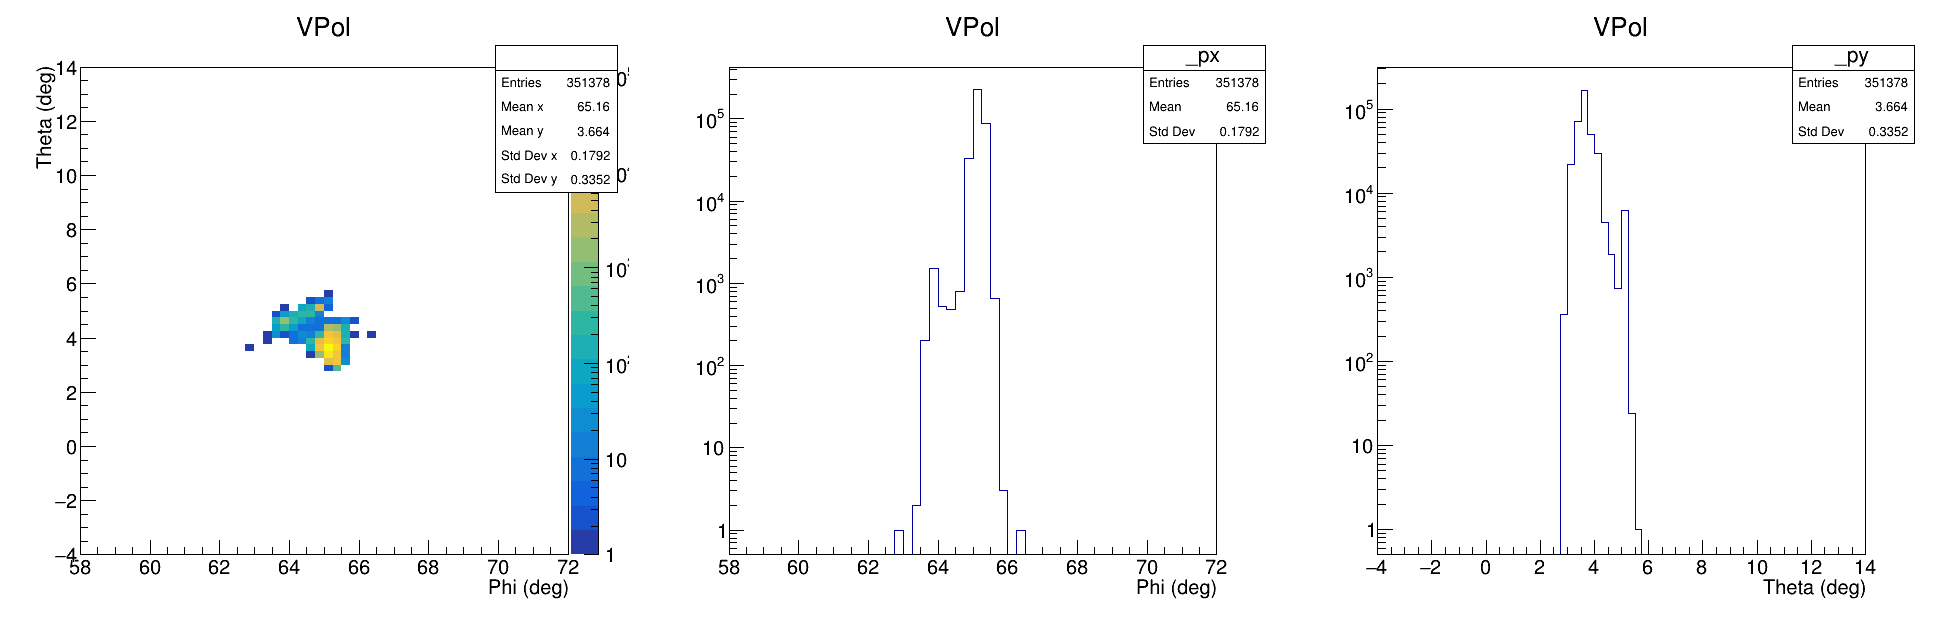

In [3]:
c=ROOT.TCanvas("","",650*3,650)
c.Divide(3,1)
c.cd(1)
vpol.Draw("COLZ")
gPad.SetLogz()
c.cd(2)
phi_proj_gaus=vpol.ProjectionX()
phi_proj_gaus.Draw()
gPad.SetLogy()
c.cd(3)
theta_proj_gaus=vpol.ProjectionY()
theta_proj_gaus.Draw()
gPad.SetLogy()
c.Draw()

In [4]:
phi_calpul_v=[]
th_calpul_v=[]
for entry in tree:
    #if(entry.peakPhi_single_out>0 and entry.peakTheta_single_out>0 ):
        phi_calpul_v.append(entry.peakPhi_single_out)
        #phi_calpul_h.append(entry.peakPhi_single[1])
        th_calpul_v.append(entry.peakTheta_single_out)
        #th_calpul_h.append(entry.peakTheta_single[1])

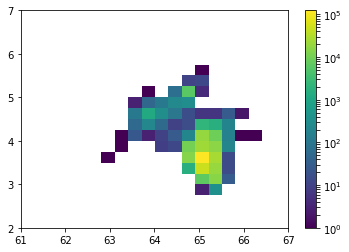

In [5]:
import matplotlib.colors as mcolors
plt.hist2d(phi_calpul_v, th_calpul_v,bins=(20,20),range=[[61, 67], [2, 7]], norm=mcolors.LogNorm());
plt.colorbar()
phi_calpul_v = np.array(phi_calpul_v)
th_calpul_v = np.array(th_calpul_v)

## Use KDE

In [6]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=50j, ybins=50j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[60.:70.:xbins, 
                      0.:10.:ybins]


    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [7]:
xx, yy, zz = kde2D(phi_calpul_v, th_calpul_v, 0.5)

### Integrate to find cut

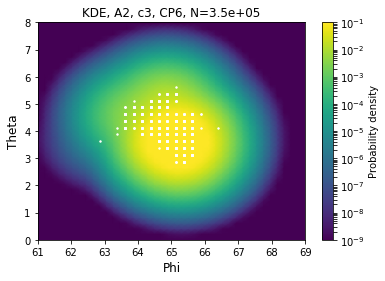

In [8]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.ticker as ticker
N=len(phi_calpul_v)
cmap = plt.get_cmap('PiYG')
cmap=plt.pcolormesh(xx, yy, zz,shading='gouraud',norm=colors.LogNorm(vmin=1E-9, vmax=0.1))
#plt.contour(xx, yy, zz)
# CS = plt.contour(xx, yy, zz, 6,
#                  colors='w',  # negative contours will be dashed by default
#                  levels=[1e-3/(N*10)],locator=plt.LogLocator())
# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()
# plt.clabel(CS, fontsize=11, inline=1, fmt=fmt)
plt.scatter(phi_calpul_v, th_calpul_v, s=2, facecolor="white" )
plt.colorbar(cmap,label='Probability density')
plt.ylim(0,8)
plt.xlim(61,69)
#plt.axis('equal')

plt.xlabel("Phi", size=12)
plt.ylabel("Theta",size=12)
plt.title("KDE, A2, c3, CP6, N=%0.1e" %N )
plt.savefig("/users/PCON0003/cond0068/ARA/KDE_A2_c3_CP6.png", dpi=200)

In [11]:
def getProb(KDE_x,KDE_y, KDE_z, N):
    """"Inputs are the x,y,z arrays from the KDE output, and the number of data
        outputs are 3 arrays, x,y and the probability
    """
    from scipy.integrate import simps
    x_array=np.array(KDE_x)
    x_array.shape
    y_array=np.array(KDE_y)

    x_reshaped=x_array.reshape(2500)
    y_reshaped=y_array.reshape(2500)

    x_integ=np.unique(x_reshaped)
    y_integ=np.unique(y_reshaped)
    bins=np.arange(0,50,1)
    integral_array=[]
    for n in bins:
        integral=simps([simps(zz_x,x_integ[n::]) for zz_x in KDE_z[n::,n::]],y_integ[n::]) 
        integral_array.append(N*integral)
    
    return x_integ, y_integ, integral_array
    

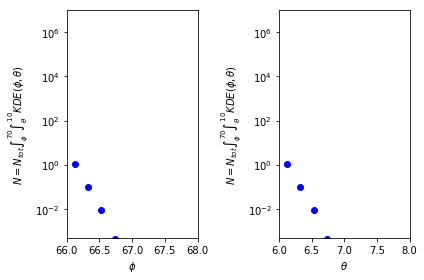

In [14]:
x_6,y_6,prob_6=getProb(xx,yy,zz,N)

### Plot probability

plt.subplot(1, 2, 1)

plt.plot(x_6, prob_6, "o",color="blue")
plt.yscale("log")
plt.xlabel(r"$\phi$")
plt.xlim(66,68)
plt.ylim((1e-3)/2,1e7)
plt.ylabel("$N=N_{tot}\int_{\phi}^{70}\int_{\\theta}^{10}{KDE(\phi,\\theta)}$")


plt.subplot(1, 2, 2)

plt.plot(y_6, prob_6, "o",color="blue")
plt.yscale("log")
plt.xlabel(r"$\theta$")
plt.xlim(6,8)
plt.ylim((1e-3)/2,1e7)
plt.ylabel("$N=N_{tot}\int_{\phi}^{70}\int_{\\theta}^{10}{KDE(\phi,\\theta)}$")

plt.tight_layout()
#plt.savefig("/users/PCON0003/cond0068/ARA/KDE_A2_c1_CP6_integral_unit.png", dpi=200)

## Final cuts

$$ \vec{X_1}=(63.6,0.6) $$
$$ \vec{X_2}=(66.8,6.8) $$

## Fit the distros

In [9]:
phi_proj=vpol.ProjectionX()
theta_proj=vpol.ProjectionY()


j1 = ROOT.TF1("n1","gaus",1,3)
j2 = ROOT.TF1("n2","gaus",3,5)
j3 = ROOT.TF1("n2","gaus",4.5,6)

#phi.Fit("gaus","S")
total_th = ROOT.TF1("nstotal","gaus(3)+gaus(6)",1,6)
total_th.SetLineColor(4)
theta_proj.Fit(j1,"0R");
theta_proj.Fit(j2,"0RQ+");
theta_proj.Fit(j3,"0RQ+");
mean_th=np.zeros(9)
for i in range(0,3):
    mean_th[i]=j1.GetParameter(i)
for i in range(3,6):
    mean_th[i]=j2.GetParameter(i-3)
for i in range(6,9):
    mean_th[i]=j3.GetParameter(i-6)
total_th.SetParameters(mean_th);
allfit_theta=theta_proj.Fit(total_th,"ESLRQ+")

g1 = ROOT.TF1("m1","gaus",62,64)
g2 = ROOT.TF1("m2","gaus",62,70)
#g3 = ROOT.TF1("m2","gaus",62,65)

#The total is the sum of the three, each has 3 parameters
total = ROOT.TF1("mstotal","gaus(0)+gaus(3)",60,72)
total.SetLineColor(4)
phi_proj.Fit(g1,"0R");
phi_proj.Fit(g2,"0RQ+");
phi_proj.Fit(g3,"0RQ+");

mean=np.zeros(6)
for i in range(0,3):
    mean[i]=g1.GetParameter(i)
for i in range(3,6):
    mean[i]=g2.GetParameter(i-3)
# for i in range(6,9):
#     mean[i]=g3.GetParameter(i-6)
total.SetParameters(mean);
allfit=phi_proj.Fit(total,"ELRQS+")


NameError: name 'g3' is not defined

 FCN=1.18078e-10 FROM HESSE     STATUS=NOT POSDEF     16 CALLS          84 TOTAL
                     EDM=2.3592e-10    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.68560e+02   3.68225e+02   2.41152e-03   8.80038e-07
   2  Mean         3.05744e+00   2.71541e-01   1.78150e-06  -1.19142e-03
   3  Sigma        2.51279e-01   3.58708e-01   3.26480e-06   6.50227e-04
 FCN=1 FROM MIGRAD    STATUS=CONVERGED     352 CALLS         353 TOTAL
                     EDM=8.69921e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.69512e+03   2.36454e+02   2.81782e-02   2.62893e-09
   2  Mean         6.39471e+01   5.50906e-02   3.04924e-05  -1.17407e-03
   3  Sigma        1.55793e-01   2.1

In [ ]:
c=ROOT.TCanvas("","",650*3,650)
phi_int=total.Integral(-27,-21)
th_int=total_th.Integral(-30,-18)
name_ph="Phi Projection Near peak, Integral="+ str(phi_int)
name_th="Theta Projection Near peak, Integral="+ str(th_int)
c.Divide(2,1)

c.cd(1)
phi_proj.Draw()
gPad.SetLogy()
gStyle.SetOptFit(1111)
phi_proj.SetTitle("Phi distr., A2, c3, Calpulser 6, VPol")
c.cd(2)
theta_proj.SetTitle("Theta distr., A2, c3, Calpulser 6, VPol")
theta_proj.Draw()
gPad.SetLogy()
gStyle.SetOptFit(1111)
c.Draw()